This notebook is used to make plots. The notebook is converted to a plain python text file using [jupytext](https://jupytext.readthedocs.io/en/latest/)

In [2]:
import numpy as np
import pandas as pd
!pip install xarray

Defaulting to user installation because normal site-packages is not writeable


In [13]:
aa_a_1k = pd.read_csv("csv_files/Active learning results - new - AA_A_1k.csv")

In [15]:
aa_a_1k.mean_vals

0     0.547348
1     0.405195
2     0.345960
3     0.304385
4     0.277288
5     0.257633
6     0.241584
7     0.226030
8     0.216310
9     0.209477
10    0.201103
11    0.193271
12    0.186277
13    0.178212
14    0.172891
15    0.167611
16    0.164436
Name: mean_vals, dtype: float64

In [4]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
# print(os.getcwd())
# !module load python-data/3.7.6-1
# !python -m pip install jupytext
!python -m jupytext --sync MakePlots.ipynb

[jupytext] Reading MakePlots.ipynb in format ipynb
[jupytext] Updating MakePlots.py


# Energy (x) vs Uncertainty (y) plot
In this plot we load the python model for each batch in run 1 of a given Dataset/Strategy/Batches combo (e.g. AA_D_EXP ) and make a plot which shows where was the uncertainty reduced the most. The data for this plot is present in `Puhti` under `/scratch/project_2000382/ghoshkun/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs`

In [8]:
import os
os.getcwd()

'/scratch/project_2000382/ghoshkun/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs'

Set the current working directory to where the data exists

In [14]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
assert os.getcwd() == "/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs"

TODO : For the plot with the new data, save the means and standard deviation.

# Data savings plot

The code is based on the original implementation in 

In [142]:
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")
print(os.getcwd())
aa_a_1k = pd.read_csv("csv_files/Active_learning_results - AA_A_1k.csv")
aa_d_1k = pd.read_csv("csv_files/Active_learning_results - AA_D_1k.csv")

aa_a_2k = pd.read_csv("csv_files/Active_learning_results - AA_A_2k.csv")
aa_d_2k = pd.read_csv("csv_files/Active_learning_results - AA_D_2k.csv")

aa_a_4k = pd.read_csv("csv_files/Active_learning_results - AA_A_4k.csv")
aa_d_4k = pd.read_csv("csv_files/Active_learning_results - AA_D_4k.csv")

aa_a_8k = pd.read_csv("csv_files/Active_learning_results - AA_A_8k.csv")
aa_d_8k = pd.read_csv("csv_files/Active_learning_results - AA_D_8k.csv")


/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs


In [143]:
from collections import namedtuple
Dataset = namedtuple("Dataset", "strategy mean_val std_val coeff")

# get_named_tuple
# QM9 = Dataset(["A","D"], 
#               [aa_a_1k.mean_vals.to_numpy(), aa_d_1k.mean_vals.to_numpy()],
#               [aa_a_1k.std_vals.to_numpy(), aa_d_1k.std_vals.to_numpy()],
#               []
#              )
# create a list of lists with means and standard deviations
# def get_means_stds(list_of_dfs):
#     for df in list_of_dfs:

In [169]:
# formatting plots
font = {'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 15}
lines = {"linewidth": 4}

matplotlib.rc('font', **font)
matplotlib.rc('lines', **lines)

batch_size = 8 # 1 for 1k, 2 for 2k etc
batch_sizes = np.arange(0,17,batch_size) + 1
labels = "A B C D E F G".split(" ")
labs = [[_] for _ in labels]

aa_a_means = aa_a_8k.mean_vals.to_numpy()
aa_d_means = aa_d_8k.mean_vals.to_numpy()

aa_a_stds = aa_a_8k.std_vals.to_numpy()
aa_d_stds = aa_d_8k.std_vals.to_numpy()


stds = [aa_a_stds,
     [],
     [],
     aa_d_stds,
     [],
     [],
     []]

means = [aa_a_means,
     [],
     [],
     aa_d_means,
     [],
     [],
     []]

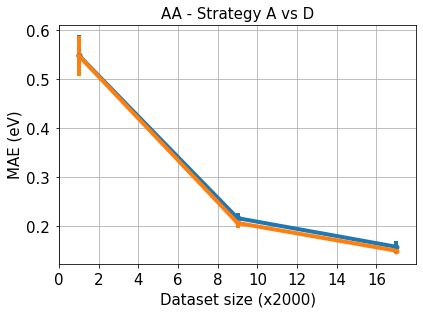

In [181]:
def plot_strategy_a_vs_d(dataset_name, means, stds):
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
            _ = plt.errorbar(batch_sizes, mean, std, capsize=lines['linewidth'])
            _ = plt.scatter(batch_sizes, mean, label=labels[idx])
    plt.grid()
    plt.xlabel("Dataset size (x2000)")
    plt.ylabel("MAE (eV)")
    plt.xlim((0, 18))
    plt.xticks(range(0, 17, 2))
    plt.title(f"{dataset_name} - Strategy A vs D")

plot_strategy_a_vs_d(dataset_name = "AA", means=means, stds=stds)    

In [1]:
from scipy.optimize import curve_fit

def fit_curve_to_data(means, stds, labels, batch_sizes):
    coeffs = { 'A' : None, 'D' : None }
    mean_dict = {'A' : None, 'D' : None}
    for idx, (mean, std) in enumerate(zip(means,stds)):
        if labels[idx] in ['A', 'D']:
            """
            Only plot strategy A and D.
            """
            results = curve_fit(lambda x,a,b,c,d: d + (a-d)/(1 + (x/c)**b), batch_sizes, mean, p0=[0.5, 0.5, 0.5, 0.5], bounds=(-1, [3., 1., 2, 2]))
            a, b, c, d= results[0]
            coeffs[labels[idx]] = results[0]
            mean_dict[labels[idx]] = mean

            x = batch_sizes # np.arange(0, 17, batch_size)
            y = d + (a-d)/(1 + (x/c)**b)

    return coeffs, mean_dict


# fit_curve_to_data(means, stds, labels, batch_sizes)

In [2]:
def get_data_savings(mean_dict, coeffs, batch_size, batch_sizes):
    xticks = [_ for _ in range(0,17,batch_size)]
    data_saving = []
    a,b,c,d = coeffs['D']
    for y, batch_size in zip(mean_dict['A'], batch_sizes):
        x = c * (-1 + (a-d)/(y-d))**(1./b)
        xticks.append(x)
        data_saving.append(batch_size - x)

    xticks.sort()
    xticks_str = []
    for idx, x in enumerate(xticks):
        if x in batch_sizes:
            xticks_str.append(" ")
        else:
            xticks_str.append("%.2f" % x)
    
    return data_saving

# get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


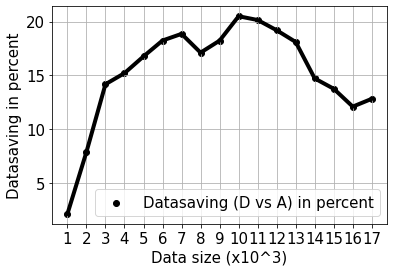

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

def plot_data_savings(strategy_a_file, strategy_d_file, batch_size):
    aa_a = pd.read_csv(strategy_a_file)
    aa_d = pd.read_csv(strategy_d_file)
    
    # formatting plots
    font = {'family' : 'normal', 'size'   : 15}
    lines = {"linewidth": 4}

    matplotlib.rc('font', **font)
    matplotlib.rc('lines', **lines)

    batch_sizes = np.arange(0,17,batch_size) + 1
    
    labels = "A B C D E F G".split(" ")
    labs = [[_] for _ in labels]

    aa_a_means = aa_a.mean_vals.to_numpy()
    aa_d_means = aa_d.mean_vals.to_numpy()

    aa_a_stds = aa_a.std_vals.to_numpy()
    aa_d_stds = aa_d.std_vals.to_numpy()


    stds = [aa_a_stds,
         [],
         [],
         aa_d_stds,
         [],
         [],
         []]

    means = [aa_a_means,
         [],
         [],
         aa_d_means,
         [],
         [],
         []]
    
    coeffs, mean_dict = fit_curve_to_data(means, stds, labels, batch_sizes)
    data_saving = get_data_savings(mean_dict, coeffs, batch_size, batch_sizes)
    
    data_saving = np.array(data_saving)
    batch_sizes = np.array(batch_sizes)

    savings_in_percent = 100 * data_saving / batch_sizes
    plt.plot(batch_sizes, savings_in_percent, color="k")
    plt.scatter(batch_sizes, savings_in_percent, color="k", label="Datasaving (D vs A) in percent")
    plt.xscale("linear")
    plt.legend()
    plt.xticks(batch_sizes)
    plt.xlabel("Data size (x10^3)")
    plt.ylabel("Datasaving in percent")
    plt.grid()
    
os.chdir("/projappl/project_2000382/ghoshkun/code/Multi_Fidelity_Prediction_GP/mfgp/task1_new/puhti_runs")    
plot_data_savings(strategy_a_file = "csv_files/Active_learning_results - AA_A_1k.csv",
                  strategy_d_file = "csv_files/Active_learning_results - AA_D_1k.csv",
                  batch_size=1) # 1 for 1k, 2 for 2k etc

Batch sizes [ 1  9 17]
datasavings [0.00331871 0.81299072 1.65905066]
datasavings [0.33187076 9.03323019 9.75912156]


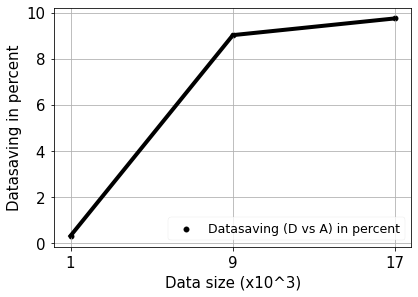

In [173]:
data_saving = np.array(data_saving)
batch_sizes = np.array(batch_sizes)
print(f"Batch sizes {batch_sizes}")
savings_in_percent = 100 * data_saving / batch_sizes
print(f"datasavings {data_saving}")
plt.plot(batch_sizes, savings_in_percent, color="k")
print(f"datasavings {savings_in_percent}")
plt.scatter(batch_sizes, savings_in_percent, color="k", label="Datasaving (D vs A) in percent")
plt.xscale("linear")
plt.legend()
plt.xticks(batch_sizes)
plt.xlabel("Data size (x10^3)")
plt.ylabel("Datasaving in percent")
plt.grid()

# Distribution of molecule count per energy range

Done for AA and QM9

In [40]:
from matplotlib import pyplot as plt

import os
import numpy as np
import matplotlib
%matplotlib inline

plt.style.use('seaborn-paper')
font = {'size'   : 20}
labelsize = {'labelsize'   : 20, 'titlesize' : 20}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **labelsize)
params = {'legend.fontsize': 'small',
  'axes.labelsize': 'medium',
  'axes.titlesize':'medium',
  'xtick.labelsize':'medium',
  'ytick.labelsize':'medium'}
matplotlib.rcParams.update(params)

os.chdir("/projappl/project_2000382/ghoshkun/data")
aa = np.loadtxt("AA/HOMO.txt")
qm9 = np.loadtxt("QM9/HOMO.txt")

Text(0, 0.5, 'Percent of dataset')

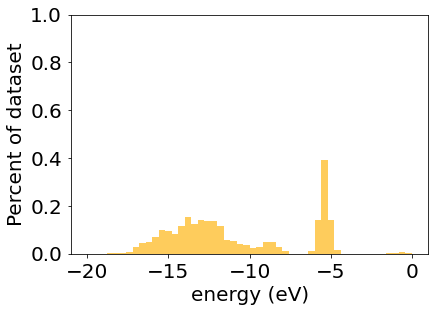

In [46]:
obj = plt.hist(aa, bins=50, density=True, color="#fecc5c",range=[-20, 0])
plt.ylim((0,1))
plt.xlabel("energy (eV)")
plt.ylabel("Percent of dataset")

Text(0, 0.5, 'Percent of dataset')

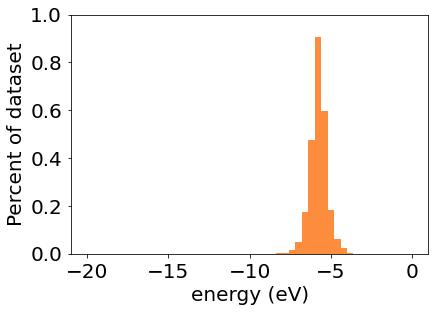

In [47]:
obj = plt.hist(qm9, bins=50, density=True, color="#fd8d3c",range=[-20, 0])  
plt.ylim((0,1))
plt.xlabel("energy (eV)")
plt.ylabel("Percent of dataset")